# Kaggle Competition: House Prices: Advanced Regression Techniques
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
## Part 1: Machine Learning
### Outline:
1. Preparation
2. Testing and Selecting Base Models
3. Finetuning of best model
4. Comparison with simple DLN

In [77]:
# Preparation: Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, Normalizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [49]:
# Preparation: Import processed dataset
path = 'train_processed.csv'
df = pd.read_csv(path, index_col='Id')

df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice_log
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,12.247694
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,12.109011
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,12.317167
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849398
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,12.429216


In [58]:
# Preparation: Split the dataset in train and test data
X = np.array(df.drop('SalePrice_log',axis=1))
y = np.array(df.loc[:,'SalePrice_log'])

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.6,shuffle=True)

In [63]:
# Preparation: Prepare Pipelines
poly_fit = PolynomialFeatures(degree=2)
encoder = OneHotEncoder(handle_unknown='ignore')
norm = Normalizer()
scaler = StandardScaler(with_mean=False)

lin_reg = LinearRegression()
rand_for = RandomForestRegressor()
ada_boost = AdaBoostRegressor()
grad_boost = GradientBoostingRegressor()

lin_pipe = Pipeline([('OneHotEncoder',encoder),
                     ('Normalizer',norm),
                     ('StandardScaler',scaler),
                     ('LinearRegression',lin_reg)])

rand_for_pipe = Pipeline([('OneHotEncoder',encoder),
                          ('Normalizer',norm),
                          ('StandardScaler',scaler),
                          ('RandomForest',rand_for)])

ada_boost_pipe = Pipeline([('OneHotEncoder',encoder),
                           ('Normalizer',norm),
                           ('StandardScaler',scaler),
                           ('AdaBoost',ada_boost)])

grad_boost_pipe = Pipeline([('OneHotEncoder',encoder),
                            ('Normalizer',norm),
                            ('StandardScaler',scaler),
                            ('GradientBoosting',grad_boost)])

In [64]:
# Testing and Selecting Base Models: Defining test function
def test_model(pipeline,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    
    start_time = dt.datetime.now()
    pipeline.fit(X_train,y_train)
    end_time = dt.datetime.now()
    fit_time = dt.timedelta.total_seconds(end_time-start_time)
    
    yhat_train = pipeline.predict(X_train)
    train_score = r2_score(y_train,yhat_train)
    
    yhat = pipeline.predict(X_test)
    test_score = r2_score(y_test,yhat)
    
    return np.array(fit_time,train_score,test_score)


In [70]:
# Testing and Selecting Base Models: Testing
pipe_list = [lin_pipe,rand_for_pipe,ada_boost_pipe,grad_boost_pipe]
results = np.empty((4,3))

test_map = map(test_model,pipe_list)
i = 0
for result in test_map:
    results[i]=result
    i+=1

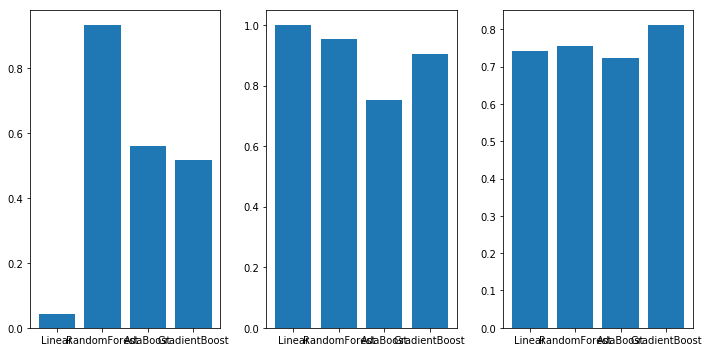

In [93]:
# Testing and Selecting Base Models: Visualize Test Results
fig,ax = plt.subplots(figsize=(10,5))
names = ['Linear','RandomForest','AdaBoost','GradientBoost']

for col in range(3):
    plt.subplot(1,3,col+1)
    plt.bar(x=names,height=results[:,col])
    
plt.tight_layout()
plt.show()

In [88]:
print(results)
print(results[:,0])

[[0.043941   1.         0.74235346]
 [0.933626   0.95466919 0.75591531]
 [0.561348   0.75271121 0.7234337 ]
 [0.516603   0.90420283 0.81130471]]
[0.043941 0.933626 0.561348 0.516603]
